# Public data exploration

The objective of this notebook is to explore some public dataset that may be used to feed a realistic dataset of care trajectories.

We explore datasets that can help to create a realistic population of patient (bases on demographic datasets) and datasets about care deliveries.

There are two main sources of the datasets:

- the Ministry of Health that provides aggregate statistics from the SNIIRAM database about the cares. This figures are very interesting in our case because it contains statistics coming from the original data we are mimicing.
- the INSEE (french national institute of statistics). It provides useful information about the french population demography.

<span style="color:orange;">**WARNING**: data are sometimes huge! I did not save them in the Git repository. For each experiment, the source of the data are given and assumed to be saved in the `../data` repository.</span>


## Prelimiaries
Some library import

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import zipfile

## Open medic dataset
source: https://www.data.gouv.fr/fr/datasets/open-medic-base-complete-sur-les-depenses-de-medicaments-interregimes/

Open medic is a dataset which contains aggregated counts of deliveries of medics to the French population. It originates from the SNIIRAM dataset. There is no information about the location of drug deliveries or location of beneficiaries.

Load the open medic CSV dataset from the zip file thanks to the pandas library!

In [134]:
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")
#remove labels of drugs (just keep the codes)
try:
    del(data['l_ATC1'])
    del(data['L_ATC2'])
    del(data['L_ATC3'])
    del(data['L_ATC4'])
    del(data['L_ATC5'])
    del(data['l_cip13'])
except:
    pass

In [135]:
#show the first rows of the dataset
data

,ATC1,ATC2,ATC3,ATC4,ATC5,CIP13,TOP_GEN,GEN_NUM,age,sexe,BEN_REG,PSP_SPE,BOITES,REM,BSE
0,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,1,113,"53,31","191,53"
1,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,12,152,"77,60","258,68"
2,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,90,74,"33,50","126,72"
3,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,5,98,13,"6,56","21,87"
4,A,A01,A01A,A01AA,A01AA01,3400931911999,0,0,0,1,11,1,106,"39,47","136,74"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829854,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,1,19,"1.293,64","1.480,72"
1829855,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,3,260,"17.739,10","20.321,06"
1829856,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,90,125,"7.785,87","9.790,24"
1829857,V,V08,V08D,V08DA,V08DA05,3400935756466,0,0,60,2,93,99,27,"1.607,05","2.091,60"


The dataset gives the number of drug boxes delivered (in pharmacies, not in hospitals) 

Description of the columns

- `CIP13` is the barcode of the drug box
- `ATC5` is the classification of the drug (active component) in the international ATC taxonomy (ATC1 to ATC4 are the sublevels) 
- `age` is a class of ages of the beneficiaries  (0, 20, 60 or 99)
- `sexe` is the sexe of the beneficiaries 
- `BEN_REG` region of the beneficiaries
- `TOP_GEN` generic-brand {'0', '9', 'G', 'R', 'S'}
- `TOP_GEN` generic group (0 if none)
- `PSP_SPE` speciality of the prescriber
- `BOITES` total of drug boxes that have been delivered during year 2019 to people of given sex, in given age group with a given regime by a given prescriber's specialty
- `REM` and `BSE` are related to the costs


In [136]:
print("TOP_GEN: "+str(set(data['TOP_GEN'])))
print("GEN_NUM: "+str(set(data['GEN_NUM'])))
print("age: "+str(set(data['age'])))
print("sexe: "+str(set(data['sexe'])))
print("BEN_REG: "+str(set(data['BEN_REG'])))
print("PSP_SPE: "+str(set(data['PSP_SPE'])))


TOP_GEN: {'S', '9', 'G', 'R', '0'}
GEN_NUM: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 43, 45, 50, 51, 54, 55, 56, 57, 59, 60, 65, 66, 67, 68, 69, 70, 71, 72, 73, 78, 79, 80, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 108, 117, 118, 119, 120, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 167, 168, 170, 171, 174, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 201, 202, 203, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 230, 231, 233, 234, 237, 238, 239, 240, 241, 242, 243, 245, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 271, 272, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 293, 294, 295, 296

Remove some useless colums, and gather some lines togethers

In [137]:
try:
    del(data['ATC1'])
    del(data['ATC2'])
    del(data['ATC3'])
    del(data['ATC4'])
    del(data['TOP_GEN'])
    del(data['GEN_NUM'])
    del(data['REM'])
    del(data['BSE'])
except:
    pass

## The following lines keep only the meaningful dimensions
drugs=data.groupby(["age","sexe","ATC5","CIP13"]).agg({"BOITES":["sum"]}) #compute a group object
drugs = drugs.reset_index() #transform the group object into a dataframe
drugs.columns = drugs.columns.get_level_values(0)
print("Number of lines: %d"%len(drugs))



Number of lines: 62850


In [138]:
#show the data sorted by descending order of the number of boxes
drugs.sort_values( by=["BOITES"], ascending=False )

,age,sexe,ATC5,CIP13,BOITES
53604,60,2,N02BE01,3400935955838,40447065
31408,20,2,N02BE01,3400935955838,38276594
42593,60,1,N02BE01,3400935955838,28024402
20468,20,1,N02BE01,3400935955838,26999028
53646,60,2,N02BE01,3400941533969,19047699
...,...,...,...,...,...
19917,20,1,M03BX05,3400935972057,-21
30842,20,2,M03BX05,3400936617711,-24
53015,60,2,M03BX05,3400935971166,-34
19913,20,1,M03BX05,3400935882646,-39


Some remarks
- I have few negative counts

### Normalized drug deliveries counts

In [139]:
# Remove negative counts
drugs=drugs[drugs['BOITES']>0]

#Evaluated the totals of drug deliveries per age and per sex
drugcounts=drugs.groupby(["age","sexe"]).agg({"BOITES":["sum"]})
drugcounts = drugcounts.reset_index() #transform the group object into a dataframe
drugcounts.columns = drugcounts.columns.get_level_values(0)
drugcounts.rename( columns={'BOITES':'count'}, inplace=True)

In [140]:
# We now compute the frequency of the deliveries for each drug per group of sex and age
drug_freq=pd.merge(drugs,drugcounts,how='left', on=['age','sexe'])
drug_freq['freq']=drug_freq['BOITES']/drug_freq['count']
drug_freq

,age,sexe,ATC5,CIP13,BOITES,count,freq
0,0,1,A01AA01,3400931911999,5341,90180305,0.000059
1,0,1,A01AA01,3400932742417,3318,90180305,0.000037
2,0,1,A01AA01,3400933616786,1178,90180305,0.000013
3,0,1,A01AA01,3400934089480,6137,90180305,0.000068
4,0,1,A01AA02,3400932409860,521,90180305,0.000006
...,...,...,...,...,...,...,...
62825,99,9,V08CA04,3400935082886,14,194290,0.000072
62826,99,9,V08CA04,3400935082947,11,194290,0.000057
62827,99,9,V08CA08,3400938879728,29,194290,0.000149
62828,99,9,V08CA09,3400936080218,16,194290,0.000082


# Population datasets

Source: https://www.insee.fr/fr/statistiques/1893204#consulter

Datasets about population demography are provided by INSEE.
There are several dataset publicly available that may be useful:
- Sexe/Age/Quinquennal dataset provide population count by sex and city, but it is aggregated by age (5 years)
- the population dataset provides information, per yearly age and sex, of the national population. My idea is to use this dataset of redistribute the population in the 5 years group (and by sex) of people according to the national distribution of this group of people.
- population dataset maybe useful to get the zip code of cities

In [161]:
pop_saq = pd.read_csv("../data/pop-sexe-age-quinquennal.zip", header=0, sep=',', encoding="latin_1", dtype={'DR':str,'DR18':str })
pop_saq.dropna(inplace=True) #some cities disappeared leading to none lines
try:
    #remove some a priori useless columns
    del(pop_saq['RR'])
    del(pop_saq['CR'])
    del(pop_saq['DR'])
    del(pop_saq['STABLE'])
except:
    pass

#Gather all the columns in a unique column with variables to describe them ('sex' and 'age')
pop_saq=pop_saq.melt(id_vars=['DR18','LIBELLE'])
tmp=pop_saq['variable'].str.extract(r'ageq_rec(?P<age>\d+)s(?P<sex>\d)rpop2016')
pop_saq=pd.concat([tmp,pop_saq],axis=1)
pop_saq['age']=(pd.to_numeric(pop_saq['age'])-1)*5 #counts for 5 years intervals of ages
del(tmp)
del(pop_saq['variable'])

#rename columns
pop_saq=pop_saq.rename(columns={'LIBELLE':'Ville', 'DR18':'dpt'})
pop_saq['Ville']=pop_saq['Ville'].str.lower()

pop_saq

,age,sex,dpt,Ville,value
0,0,1,01,abergement-clémenciat,15.000000
1,0,1,01,abergement-de-varey,5.000000
2,0,1,01,ambérieu-en-bugey,529.591402
3,0,1,01,ambérieux-en-dombes,25.555140
4,0,1,01,ambléon,5.000000
...,...,...,...,...,...
1416115,95,2,974,sainte-suzanne,10.082253
1416116,95,2,974,salazie,5.135268
1416117,95,2,974,tampon,55.228924
1416118,95,2,974,trois-bassins,0.000000


Note that I don't know yet why there are real-valued counts !!

In [162]:
pop_france = pd.read_csv("../data/pop-totale-france-metro.zip", header=0, sep=',', encoding="latin_1")
del(pop_france["Année de naissance"])
del(pop_france["Ensemble"])
pop_france.rename(columns={"Âge révolu":"age", "Nombre d'hommes":"male", "Nombre de femmes":"female"}, inplace=True)
pop_france

,age,male,female
0,0,343009,329909
1,1,348625,333151
2,2,354653,340515
3,3,366334,350669
4,4,376914,360433
...,...,...,...
102,102,367,2490
103,103,241,1396
104,104,212,946
105,105 ou plus,638,2060


In [163]:
pop_cities = pd.read_csv("../data/population.zip", header=0, sep=';', encoding="utf-8")
pop_cities

,Code,Ville,Population2016
0,1001,L'Abergement-Clémenciat,767.0
1,1002,L'Abergement-de-Varey,243.0
2,1004,Ambérieu-en-Bugey,14081.0
3,1005,Ambérieux-en-Dombes,1671.0
4,1006,Ambléon,110.0
...,...,...,...
34963,97613,M'Tsangamouji,NaN
34964,97614,Ouangani,NaN
34965,97615,Pamandzi,NaN
34966,97616,Sada,NaN


In [169]:
#tentative de récupération des codes commune ... 
# mais les libellés ne correspondent pas exactement (des l' par exemple)
pop_cities['Ville']=pop_cities['Ville'].str.lower()

pop=pd.merge(pop_saq,pop_cities,how='left', left_on='Ville', right_on="Ville")
del(pop['Population2016'])
print(pop.columns)

pop['sex']=pop['sex'].astype('int32')
print(pop.dtypes)

unmatches=pop["Code"].isna().sum()/40
print("Estimated number of cities without code matching: %d"%(unmatches))


Index(['age', 'sex', 'dpt', 'Ville', 'value', 'Code'], dtype='object')
age        int64
sex        int32
dpt       object
Ville     object
value    float64
Code      object
dtype: object
Estimated number of cities without code matching: 2708


In [165]:
# few processing to prepare a dataset for master Telenvi
popagg=pop_cities
dpt=[s[:(len(s)-3)] for s in popagg["Code"]]
popagg["Code"]=dpt

popagg=popagg.groupby(["Code"]).agg({"Population2016":["sum"]})

popagg.reset_index(inplace=True)
popagg.columns = popagg.columns.get_level_values(0)
popagg

popagg.to_csv('population.csv',index=False)

In [168]:
#print(popagg)

## Lets try to generate a synthetic drugs deliveries for population of Ille-et-Vilaine

### Generating a synthetic population in Ille et Vilaine

We would like to have 10000 peoples (with age above >15) that would respect the following dataset characteristics

- geographical distribution (at the level of the cities of Ille-et-Vilaine)
- gender distribution for each city
- age distribution 

In [147]:
import numpy.random as rd

pop35 = pop[ (pop["dpt"]=="35") & (pop['age']>=15)]
#print(pop35)
print(pop35[pop35["Code"].isna()]["Ville"].unique())
print("(Estimated) number of cities that disappeared from the dataset: %d."%(pop35["Code"].isna().sum()/40))      

#remove matching for cities having the same name, but not in the same departement
pop35=pop35[ pop35["Code"].str.zfill(5).str[:2]==pop35["dpt"] ]

pop35["freq"] = pop35["value"]/sum(pop35["value"])
#pop35.iloc(Index[0])

['antrain' 'baillé' 'baussaine' 'bazouge-du-désert' 'bosse-de-bretagne'
 'bouëxière' 'brulais' 'chancé' 'chapelle-aux-filtzméens'
 'chapelle-bouëxic' 'chapelle-chaussée' 'chapelle-des-fougeretz'
 'chapelle du lou du lac' 'chapelle-erbrée' 'chapelle-janson'
 'chapelle-saint-aubert' 'chapelle-de-brain' 'chapelle-thouarault'
 'châtellier' 'couyère' 'crouais' 'dominelais' 'dompierre-du-chemin'
 'ferré' 'fresnais' 'gouesnière' 'guerche-de-bretagne' 'hermitage' 'iffs'
 'lanhélin' 'loroux' 'luitré' 'mézière' 'minihic-sur-rance'
 'portes du coglais' 'noë-blanche' 'nouaye' 'pertre' 'petit-fougeray'
 'piré-sur-seiche' 'rheu' 'richardais' 'saint-georges-de-chesné'
 'saint-jean-sur-couesnon' 'saint-marc-sur-couesnon' "saint-m'hervon"
 'saint-ouen-la-rouërie' 'saint-pierre-de-plesguen' 'sel-de-bretagne'
 'selle-en-luitré' 'selle-guerchaise' 'theil-de-bretagne' 'tiercent'
 'tremblay' 'tresb?uf' 'tressé' 'vendel' 'verger' 'ville-ès-nonais'
 'vivier-sur-mer' 'tronchet']
(Estimated) number of cities th

In [148]:
#generation of a synthetic population of size `synth_pop_size`
synth_pop_size=10000
Index=rd.choice(np.array(pop35.index), synth_pop_size, p=np.array(pop35["freq"]), replace=True)

synthpop=pop35.loc[Index]
synthpop.reset_index(inplace=True)

del(synthpop['value'])
del(synthpop['freq'])
synthpop['age'] = synthpop['age']+rd.randint(0,5,size=len(synthpop))


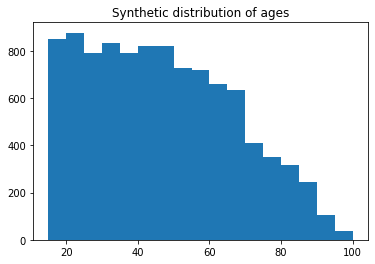

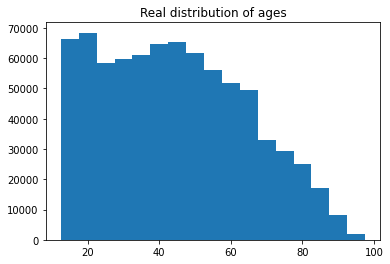

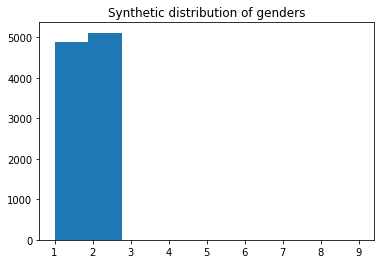

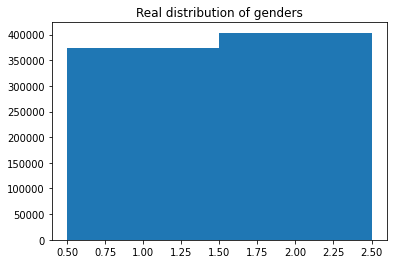

In [149]:
#### Distribution of ages
plt.hist(synthpop['age'],range=(15,100),bins=17)
plt.title("Synthetic distribution of ages")
plt.show()


page=pop35.groupby(['age']).agg({'value':"sum"})
plt.figure()
plt.bar(page.index,page['value'],width=5)
plt.title("Real distribution of ages")
plt.show()

#### Distribution of genders
plt.figure()
plt.hist(synthpop['sex'],bins=9,range=(1,9))
plt.title("Synthetic distribution of genders")
plt.show()


page=pop35.groupby(['sex']).agg({'value':"sum"})
plt.figure()
plt.bar(page.index,page['value'],width=1)
plt.title("Real distribution of genders")
plt.show()

### Generation of drugs deliveries for the population
What we need:

- `drug_freq` the frequency of drug deliveries per age and per sex
- `synthpop` the synthetic population of Ille et Vilaine

In [150]:
drugfreq_020_1 = drug_freq[ (drug_freq['age']==0) & (drug_freq['sexe']==1) ]


drugfreq_020_2 = drug_freq[ (drug_freq['age']==0) & (drug_freq['sexe']==2) ]
drugfreq_2060_2 = drug_freq[ (drug_freq['age']==20) & (drug_freq['sexe']==2) ]
drugfreq_2060_1 = drug_freq[ (drug_freq['age']==20) & (drug_freq['sexe']==1) ]
drugfreq_6090_1 = drug_freq[ (drug_freq['age']==60) & (drug_freq['sexe']==1) ]
drugfreq_6090_2 = drug_freq[ (drug_freq['age']==60) & (drug_freq['sexe']==2) ]
drugfreq_90_1 = drug_freq[ (drug_freq['age']==90) & (drug_freq['sexe']==1) ]
drugfreq_90_2 = drug_freq[ (drug_freq['age']==90) & (drug_freq['sexe']==2) ]


def generate(p):
    if p['age']<20:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=20,scale=5)))
            drugs=rd.choice(np.array(drugfreq_020_1['CIP13']), nb, p=np.array(np.array(drugfreq_020_1['freq'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=20,scale=10)))
            drugs=rd.choice(np.array(drugfreq_020_2['CIP13']), nb, p=np.array(np.array(drugfreq_020_2['freq'])), replace=True)
            return drugs
    elif p['age']<40:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=50,scale=10)))
            drugs=rd.choice(np.array(drugfreq_2060_1['CIP13']), nb, p=np.array(np.array(drugfreq_2060_1['freq'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=50,scale=10)))
            drugs=rd.choice(np.array(drugfreq_2060_2['CIP13']), nb, p=np.array(np.array(drugfreq_2060_2['freq'])), replace=True)
            return drugs
    elif p['age']<90:
        if p['sex']==1:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=rd.choice(np.array(drugfreq_6090_1['CIP13']), nb, p=np.array(np.array(drugfreq_6090_1['freq'])), replace=True)
            return drugs
        elif p['sex']==2:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=rd.choice(np.array(drugfreq_6090_2['CIP13']), nb, p=np.array(np.array(drugfreq_6090_2['freq'])), replace=True)
            return drugs
    else:
        if p['sex']==1 and len(drugfreq_90_1['CIP13'])>0:
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=rd.choice(np.array(drugfreq_90_1['CIP13']), nb, p=np.array(np.array(drugfreq_90_1['freq'])), replace=True)
            return drugs
        elif p['sex']==2 and len(drugfreq_90_2['CIP13'])>0 :
            nb=int(np.abs(rd.normal(loc=80,scale=10)))
            drugs=rd.choice(np.array(drugfreq_90_2['CIP13']), nb, p=np.array(np.array(drugfreq_90_2['freq'])), replace=True)
            return drugs
        else:
            return []
        
print("generate")
df=synthpop.apply(generate, axis=1)
print("stacking")
deliveries = df.apply(pd.Series).stack().reset_index(drop=True)
print("done")

generate
stacking
done


### Compute the mean number of deliveries per patient

The number of deliveries can be obtained by computing the total number of drug boxes delivered for a group of patients (per age and sex) divided by the total amount of people in this group (known through `pop_saq`)

In [151]:
mean_nb_boxes=np.sum(drugfreq_020_1['count'])/np.sum(pop_saq[ (pop_saq["age"]>=0) & (pop_saq["age"]<=15) & (pop_saq['sex']=="1") ]['value'])
print(mean_nb_boxes)

mean_nb_boxes=np.sum(drugfreq_020_2['count'])/np.sum(pop_saq[ (pop_saq["age"]>=0) & (pop_saq["age"]<=15) & (pop_saq['sex']=="2") ]['value'])
print(mean_nb_boxes)

mean_nb_boxes=np.sum(drugfreq_2060_1['count'])/np.sum(pop_saq[ (pop_saq["age"]>=20) & (pop_saq["age"]<=55) & (pop_saq['sex']=="1") ]['value'])
print(mean_nb_boxes)

mean_nb_boxes=np.sum(drugfreq_2060_2['count'])/np.sum(pop_saq[ (pop_saq["age"]>=20) & (pop_saq["age"]<=55) & (pop_saq['sex']=="2") ]['value'])
print(mean_nb_boxes)

mean_nb_boxes=np.sum(drugfreq_6090_1['count'])/np.sum(pop_saq[ (pop_saq["age"]>=60) & (pop_saq["age"]<=85) & (pop_saq['sex']=="1") ]['value'])
print(mean_nb_boxes)

mean_nb_boxes=np.sum(drugfreq_6090_2['count'])/np.sum(pop_saq[ (pop_saq["age"]>=60) & (pop_saq["age"]<=85) & (pop_saq['sex']=="2") ]['value'])
print(mean_nb_boxes)

65188.37970580895
73694.83261689912
231426.06054205203
327101.91647131427
807273.0522653859
920318.7678570674


The results are very strange ... we have a huge number of boxes delivered per patients

- 65188 boxes per male teenager
- 73694 boxes per female teenager
- 231426 boxes per male adult
- 327101 boxes per male adult
- 807273 boxes per male elder
- 920318 boxes per male elder

# Exploration of new datasets

The same approach can be done for other kind of cares. Open data repositories give access to two other interesting datasets: 

- OpenBio that assesses the number of biology exams
- OpenDamir that assesses the number of outpatient medical acts and visits 

This last dataset contains much more details.

## Open Bio -- Biology exams
source: https://www.data.gouv.fr/fr/datasets/open-bio-base-complete-sur-les-depenses-de-biologie-medicale-interregimes/

Dataset correspondant aux biologies: donne les denombrements (`DNB`) de chaque actes de biologies par age, par sexe, par régime et par spécialisation du prescripteur.


In [152]:
import pandas as pd
biology = pd.read_csv("../data/OPEN_BIO_2018.zip", header=0, sep=';', encoding="utf-8")
del(biology["L_GRP"])
del(biology["L_ACTE"])
del(biology["REM"])
del(biology["BSE"])

biology

,GRP,ACTE,AGE,SEXE,BEN_REG,PSP_SPE,DNB
0,90,4,40,2,11,6,115
1,90,4,20,2,75,7,57
2,90,4,60,2,28,7,24
3,90,4,0,1,11,99,24
4,90,4,40,1,84,90,60
...,...,...,...,...,...,...,...
320777,29,9926,0,1,11,6,12
320778,29,9926,0,1,11,1,62
320779,29,9926,0,1,5,90,47
320780,29,9926,0,1,5,6,16


In [153]:
biology.groupby(["GRP","ACTE","AGE","SEXE"]).agg({"DNB":["sum"]})

DNB
                       sum
GRP ACTE AGE SEXE         
1   1104 0   1     1125930
             2     1543738
         20  1     2544450
             2     7383140
         40  1     6374417
...                    ...
90  8000 20  2        1241
         40  1        5566
             2        2694
         60  1        6452
             2        3457

[6409 rows x 1 columns]

## Open DAMIR data
Source: https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/

Jeu de données aggrégé sur les remboursements hors hopital. 

Le jeu indique les dénombrements de prestations (identifié par `PRS_NAT`) : `act_dnb` par CPAM (donc par departement ...), par spécialisation de l'exécutant (et son status Libéral/salarié) par TOP (?)

Il n'y a pas d'information sur les patients (sexe, age).

In [195]:
#import zipfile
#import pandas as pd
#
#zip_file = zipfile.ZipFile('../data/R2019_sans_lib.zip')
#damir = [pd.read_csv(zip_file.open(text_file.filename), header=0, sep=';', encoding="latin-1") for text_file in zip_file.infolist() if text_file.filename.endswith('.csv')]

#damir = pd.read_csv("../data/R2019_sans_lib.zip", header=0, sep=';', encoding="latin-1")
#damir

In [196]:
#zip_file = zipfile.ZipFile('../data/R2019.zip')
#for text_file in zip_file.infolist():
#    print(text_file.filename)
#    #pd.read_csv(zip_file.open(text_file.filename))

In [197]:
#damir=pd.read_csv(zip_file.open("R201901.CSV"), sep=';', encoding="latin-1")


In [198]:
damir=pd.read_csv("../data/R201901.CSV", sep=';', encoding="latin-1")

In [199]:
damir.head()

,cpam,l_cpam,dpt,l_dpt,region,l_region,l_serie,SERIE,prs_nat,l_prs_nat,...,l_exe_spe1,exe_stj1,l_exe_stj1,top_slm,l_top_slm,rem_mon,rec_mon,dep_mon,act_dnb,act_coe
0,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"0,00","0,00","0,00",0,"0,00"
1,751,751-Paris,75,75-Paris,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"31,88","39,85","9,85",2,"2,00"
2,771,771-Melun,77,77-Seine-et-Marne,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"24,00","30,00","0,00",1,"1,00"
3,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"432,00","540,00","0,00",18,"18,00"
4,781,781-Versailles,78,78-Yvelines,11,11-ILE DE FRANCE,C Omnipraticiens,111111,1098,CONSULTATION CCMU 3,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"24,00","30,00","9,85",1,"1,00"


In [202]:
#remove labels [the dataset can be downloaded without labels]
try:
    del(damir["l_cpam"])
    del(damir["dpt"])
    del(damir["l_dpt"])
    del(damir["region"])
    del(damir["l_region"])
    del(damir["l_serie"])
    del(damir["l_prs_nat"])
    del(damir["l_exe_spe"])
    del(damir["l_exe_spe1"])
    del(damir["l_exe_stj1"])
    del(damir["l_top_slm"])
    del(damir["rem_mon"])
    del(damir["rec_mon"])
    del(damir["dep_mon"])
    del(damir["act_coe"])
    del(damir["l_asu_nat"])
    del(damir["l_cpl_cod"])
    del(damir["l_pre_spe"])
    del(damir["l_pre_spe1"])
    del(damir["l_pre_stj1"])
    del(damir["REM_TAU"])
    del(damir["l_ben_qlt"])
except:
    pass
damir.head()

,cpam,SERIE,prs_nat,sns_date,asu_nat,cpl_cod,ben_qlt,pre_spe,pre_spe1,pre_stj1,exe_spe,exe_spe1,exe_stj1,top_slm,act_dnb
0,781,111111,1098,201801,1,0,2,1,1,1,1,11,1,0,0
1,751,111111,1098,201801,1,0,1,1,1,1,1,11,1,1,2
2,771,111111,1098,201801,1,0,1,1,1,1,1,11,1,0,1
3,781,111111,1098,201801,1,0,1,1,1,1,1,11,1,0,18
4,781,111111,1098,201801,1,0,1,1,1,1,1,11,1,1,1


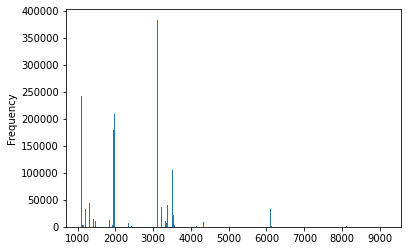

In [203]:
damir['prs_nat'].plot.hist(bins=1000)


### ALD (Affection Longue Durée)

Source des données d'ALD [https://www.data.gouv.fr/fr/datasets/personnes-en-affection-de-longue-duree-ald/]

* données ayant nécessité un peu de transformation manuelle
* tableau Excel avec deux types d'entrée: 


In [155]:
ald_per_dpt=pd.read_excel('../data/count_ALD_dpt.xls', sheet_name='dpt')
ald_per_dpt=pd.melt(ald_per_dpt,id_vars=['dpt'])
ald_per_dpt.rename(columns={'variable':'ALD'},inplace=True)

In [156]:
ald_per_dpt

,dpt,ALD,value
0,01,ALD1,3460
1,02,ALD1,3230
2,03,ALD1,3080
3,04,ALD1,1280
4,05,ALD1,1010
...,...,...,...
3025,971,ALD30,10330
3026,972,ALD30,9270
3027,973,ALD30,2110
3028,974,ALD30,12130


In [157]:
ald=ald_per_dpt.groupby(["ALD"]).agg({"value":["sum"]})
ald= ald.reset_index() #transform the group object into a dataframe
ald.columns = ald.columns.get_level_values(0)
ald.set_index("ALD", inplace=True)
ald.head()

,value
ALD,
ALD1,428490
ALD10,18645
ALD11,37415
ALD12,565260
ALD13,1170940


In [158]:
ald.loc['ALD2']

value    24925
Name: ALD2, dtype: int64

In [159]:
ald_per_dpt.head()

,dpt,ALD,value
0,01,ALD1,3460
1,02,ALD1,3230
2,03,ALD1,3080
3,04,ALD1,1280
4,05,ALD1,1010


In [160]:
## probabilities of having a living in a given Dpt knowing ALD status
pALD_per_dpt=ald_per_dpt.apply(lambda x: [x['dpt'], x['ALD'], float(x['value']/ald.loc[x['ALD']])], axis=1, result_type='expand')
pALD_per_dpt.rename(columns={0:'dpt',1:'ALD',2:'pd'},inplace=True)
pALD_per_dpt.head()

,dpt,ALD,pd
0,01,ALD1,0.008075
1,02,ALD1,0.007538
2,03,ALD1,0.007188
3,04,ALD1,0.002987
4,05,ALD1,0.002357


In [83]:
ald_per_sexeage=pd.read_excel('../data/count_ALD_dpt.xls', sheet_name='sexe-age')
ald_per_sexeage=pd.melt(ald_per_sexeage,id_vars=['Ald','Sexe'])
ald_per_sexeage.rename(columns={'Ald':'ALD', 'variable':"age", 'Sexe':'sex'},inplace=True)

In [84]:
ald_per_sexeage.head()

,ALD,sex,age,value
0,ALD1,1,0,720
1,ALD1,2,0,490
2,ALD2,1,0,100
3,ALD2,2,0,90
4,ALD3,1,0,50


In [114]:
#Recompute the number of ALD based on sex/age distribution (not exactly similar to the previous computation)
ald=ald_per_sexeage.groupby(["ALD"]).agg({"value":["sum"]})
ald= ald.reset_index() #transform the group object into a dataframe
ald.columns = ald.columns.get_level_values(0)
ald.set_index("ALD", inplace=True)
ald.head()

,value
ALD,
ALD1,428530
ALD10,18620
ALD11,37350
ALD12,565285
ALD13,1171070


In [115]:
## probabilities of having a given sexe and age knowing ALD status
pALD_per_sexeage=ald_per_sexeage.apply(lambda x: [x['sex'], x['age'], x['ALD'], float(x['value']/ald.loc[x['ALD']])], axis=1, result_type='expand')
pALD_per_sexeage.rename(columns={0:'sex',1:'age',2:'ALD',3:'psa'},inplace=True)
pALD_per_sexeage.head()

,sex,age,ALD,psa
0,1,0,ALD1,0.001680
1,2,0,ALD1,0.001143
2,1,0,ALD2,0.004018
3,2,0,ALD2,0.003616
4,1,0,ALD3,0.000092


In [116]:
## probabilities of having a given sex and age, and living in a given Dpt knowing ALD status
pALD=pd.merge(pALD_per_sexeage,pALD_per_dpt, how='inner', on='ALD')
pALD['p']=pALD['psa']*pALD['pd']
pALD=pALD[['sex','age','dpt','ALD','p']]
pALD

,sex,age,dpt,ALD,p
0,1,0,01,ALD1,1.356709e-05
1,1,0,02,ALD1,1.266523e-05
2,1,0,03,ALD1,1.207706e-05
3,1,0,04,ALD1,5.019039e-06
4,1,0,05,ALD1,3.960335e-06
...,...,...,...,...,...
121195,2,95,971,ALD30,2.490335e-05
121196,2,95,972,ALD30,2.234792e-05
121197,2,95,973,ALD30,5.086743e-06
121198,2,95,974,ALD30,2.924275e-05


In [117]:
#check that it sums to 1 for some ALD types
np.sum( pALD[pALD['ALD']=='ALD2']['p'] )

1.0

In [121]:
#then, the probability to have an ALD knowing the Sex, Age and Dpt is given by
# p(ALD|D,S,A) = p(D,S,A | ALD) * p(ALD) / p(D,S,A)
#    p(ALD) is given by the ratio of number of ALD and the total population
pop_tot=np.sum(pop['value'])
ald['pALD']=ald['value']/pop_tot
ald.reset_index(inplace=True)
P = pd.merge(pALD, ald[['ALD',"pALD"]], how='inner', on='ALD')

#    p(D,S,A) is computed from the population statistics
cpop=pop.groupby(["age","sex",'dpt']).agg({"value":"sum"})
cpop= cpop.reset_index() #transform the group object into a dataframe
cpop.columns = cpop.columns.get_level_values(0)
cpop['pDSA']=cpop['value']/pop_tot

P=pd.merge(P,cpop[["age","sex",'dpt','pDSA']], how='inner', on=["age","sex",'dpt'])

P['pcALD']=P['p'] * P['pALD'] / P['pDSA']
P.head()

,sex,age,dpt,ALD,p,pALD,pDSA,pcALD
0,1,0,01,ALD1,1.356709e-05,0.005448,0.000297,0.000249
1,1,0,01,ALD2,3.062623e-05,0.000316,0.000297,0.000033
2,1,0,01,ALD3,6.606593e-07,0.006943,0.000297,0.000015
3,1,0,01,ALD4,1.609010e-04,0.000003,0.000297,0.000002
4,1,0,01,ALD5,3.192365e-05,0.013594,0.000297,0.001463


In [124]:
## Then, the final probabilities are given in cpALD variable, which give

cpALD=P[["age","sex",'dpt','ALD', 'pcALD']]
cpALD.rename(columns={'pcALD':'p'},inplace=True)
cpALD.head()

/home/tguyet/.local/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,age,sex,dpt,ALD,p
0,0,1,01,ALD1,0.000249
1,0,1,01,ALD2,0.000033
2,0,1,01,ALD3,0.000015
3,0,1,01,ALD4,0.000002
4,0,1,01,ALD5,0.001463


In [132]:
#marginal proba of having ALD2 when you live in dpt 35
dpt='23'
ALD='ALD2'
print(np.sum( cpALD[ (cpALD['ALD']==ALD) & (cpALD['dpt']==dpt)]['p'] ))
print(float(pALD_per_dpt[(pALD_per_dpt['ALD']==ALD) & (pALD_per_dpt['dpt']==dpt)]['pd']))

0.022292195520908428
0.002407221664994985
